In [1]:
import os
import re
import math
import pickle
import numpy as np
import pandas as pd

from tqdm import tqdm
from scipy.special import softmax
from utils import denoise_text, preprocess_text

from sklearn.utils.class_weight import compute_class_weight 
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

from matplotlib import pyplot as plt
from sklearn.metrics import (
    accuracy_score, roc_auc_score, 
    classification_report, confusion_matrix, ConfusionMatrixDisplay)

from IPython.display import display, Markdown, Latex

## Data

In [2]:
data = pd.read_csv("datasets/cards_waterloo.csv", low_memory=False)
data.sample()

,prompt,claim,PARTITION,labels,sentiment,tweetid,roberta_preprocessed,roberta_pred,roberta_proba,DATASET,text,cards_orignal_pred,cards_pred,cards_proba,waterloo_pred,waterloo_proba,waterloo-cards_pred,waterloo-cards_proba
70099,RT JaimeJoh: Corporations Will Never Solve Cli...,NaN,TEST,0,1.0,6.727839e+17,RT JaimeJoh: Corporations Will Never Solve Cli...,0_0,0.999359,waterloo,RT JaimeJoh: Corporations Will Never Solve Cli...,0_0,0,[9.99358710e-01 7.19976761e-06 3.64510323e-06 ...,0,[9.99989670e-01 1.03297851e-05],0,[9.99970227e-01 2.97731144e-05]


In [3]:
def format_scores(x):
    return np.array(eval(re.sub(" +", " ,", x.replace("\n", ""))))

data["cards_proba"] = data["cards_proba"].apply(format_scores)
data["waterloo_proba"] = data["waterloo_proba"].apply(format_scores)
data["waterloo-cards_proba"] = data["waterloo-cards_proba"].apply(format_scores)

In [4]:
test = data[data.PARTITION=="TEST"]

## TEST METRICS
### General Metrics

**CARDS**

Accuracy: 0.9017673653925196
AUC: 0.9201573525696802
                    precision    recall  f1-score   support

Not Misinformation       0.93      0.95      0.94      5750
    Misinformation       0.79      0.73      0.76      1549

          accuracy                           0.90      7299
         macro avg       0.86      0.84      0.85      7299
      weighted avg       0.90      0.90      0.90      7299



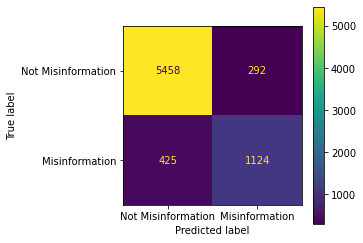

In [5]:
def report(y_true, y_pred, scores,  classes):
    
    acc = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, scores, multi_class="ovr", average="macro")

    print(f"Accuracy: {acc}")
    print(f"AUC: {roc_auc}")
    print(classification_report(y_true, y_pred, target_names=classes))
    c_m = confusion_matrix(y_true, y_pred)
    cmp = ConfusionMatrixDisplay(
        c_m, display_labels=classes)
    fig, ax = plt.subplots(figsize=(4,4))
    cmp.plot(ax=ax)  
    
target_names = ["Not Misinformation", "Misinformation"]
display(Markdown("**CARDS**"))
scores = test['cards_proba'].apply(lambda x: sum(x[1:]))
report(test.labels, test['cards_pred'], scores, target_names)

**WATERLOO**

Accuracy: 0.8490204137553089
AUC: 0.8806229545008001
                    precision    recall  f1-score   support

Not Misinformation       0.86      0.96      0.91      5750
    Misinformation       0.75      0.44      0.55      1549

          accuracy                           0.85      7299
         macro avg       0.81      0.70      0.73      7299
      weighted avg       0.84      0.85      0.83      7299



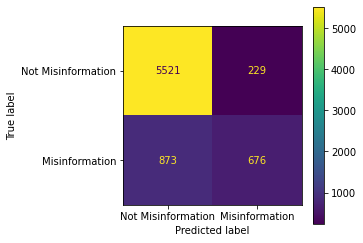

In [6]:
display(Markdown("**WATERLOO**"))
scores = test['waterloo_proba'].apply(lambda x: sum(x[1:]))
report(test.labels, test['waterloo_pred'], scores, target_names)

**WATERLOO-CARDS**

Accuracy: 0.9341005617207837
AUC: 0.9715538215398434
                    precision    recall  f1-score   support

Not Misinformation       0.95      0.97      0.96      5750
    Misinformation       0.88      0.80      0.84      1549

          accuracy                           0.93      7299
         macro avg       0.91      0.88      0.90      7299
      weighted avg       0.93      0.93      0.93      7299



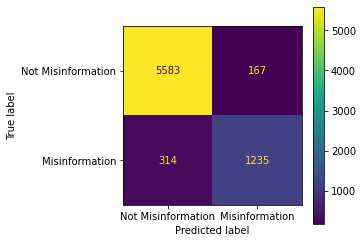

In [7]:
display(Markdown("**WATERLOO-CARDS**"))
scores = test['waterloo-cards_proba'].apply(lambda x: sum(x[1:]))
report(test["labels"], test['waterloo-cards_pred'], scores, target_names)

### Over Waterloo Segment

In [8]:
test_waterloo = data[(data.PARTITION=="TEST") & (data.DATASET=="waterloo")]

**CARDS waterloo segment**

Accuracy: 0.8996587030716724
AUC: 0.79030847890497
                    precision    recall  f1-score   support

Not Misinformation       0.94      0.95      0.95      3996
    Misinformation       0.44      0.40      0.42       399

          accuracy                           0.90      4395
         macro avg       0.69      0.67      0.68      4395
      weighted avg       0.90      0.90      0.90      4395



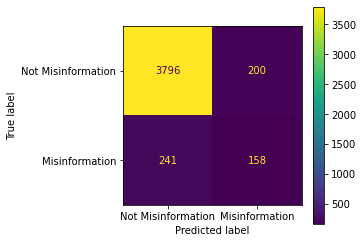

In [9]:
display(Markdown("**CARDS waterloo segment**"))
scores = test_waterloo['cards_proba'].apply(lambda x: sum(x[1:]))
report(test_waterloo.labels, test_waterloo['cards_pred'], scores, target_names)

**WATERLOO waterloo segment**

Accuracy: 0.9610921501706484
AUC: 0.9751991966904247
                    precision    recall  f1-score   support

Not Misinformation       0.98      0.98      0.98      3996
    Misinformation       0.79      0.77      0.78       399

          accuracy                           0.96      4395
         macro avg       0.89      0.88      0.88      4395
      weighted avg       0.96      0.96      0.96      4395



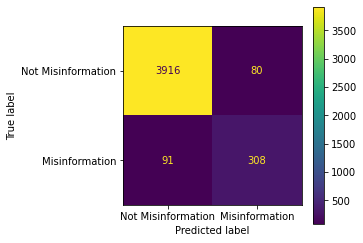

In [10]:
display(Markdown("**WATERLOO waterloo segment**"))
scores = test_waterloo['waterloo_proba'].apply(lambda x: sum(x[1:]))
report(test_waterloo.labels, test_waterloo['waterloo_pred'], scores, target_names)

**WATERLOO-CARDS in waterloo segment**

Accuracy: 0.9581342434584755
AUC: 0.9695234081198993
                    precision    recall  f1-score   support

Not Misinformation       0.98      0.98      0.98      3996
    Misinformation       0.77      0.76      0.77       399

          accuracy                           0.96      4395
         macro avg       0.87      0.87      0.87      4395
      weighted avg       0.96      0.96      0.96      4395



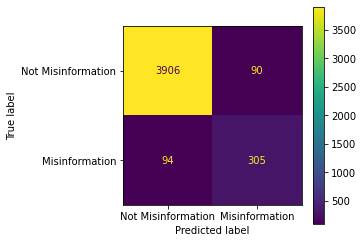

In [11]:
display(Markdown("**WATERLOO-CARDS in waterloo segment**"))
scores = test_waterloo['waterloo-cards_proba'].apply(lambda x: sum(x[1:]))
report(test_waterloo["labels"], test_waterloo['waterloo-cards_pred'], scores, target_names)

### Over CARDS segment

In [12]:
test_cards = data[(data.PARTITION=="TEST") & (data.DATASET=="cards")]

**CARDS in cards segment**

Accuracy: 0.9049586776859504
AUC: 0.9634829706013585
                    precision    recall  f1-score   support

Not Misinformation       0.90      0.95      0.92      1754
    Misinformation       0.91      0.84      0.87      1150

          accuracy                           0.90      2904
         macro avg       0.91      0.89      0.90      2904
      weighted avg       0.91      0.90      0.90      2904



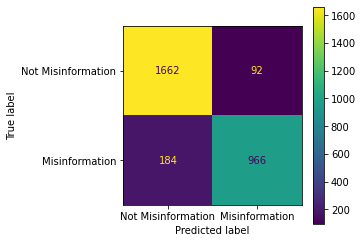

In [13]:
display(Markdown("**CARDS in cards segment**"))
scores = test_cards['cards_proba'].apply(lambda x: sum(x[1:]))
report(test_cards.labels, test_cards['cards_pred'], scores, target_names)

**WATERLOO waterloo segment**

Accuracy: 0.6794077134986226
AUC: 0.7067894502007833
                    precision    recall  f1-score   support

Not Misinformation       0.67      0.92      0.78      1754
    Misinformation       0.71      0.32      0.44      1150

          accuracy                           0.68      2904
         macro avg       0.69      0.62      0.61      2904
      weighted avg       0.69      0.68      0.64      2904



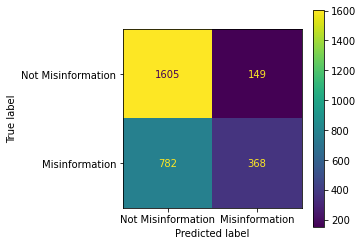

In [14]:
display(Markdown("**WATERLOO waterloo segment**"))
scores = test_cards['waterloo_proba'].apply(lambda x: sum(x[1:]))
report(test_cards.labels, test_cards['waterloo_pred'], scores, target_names)

**WATERLOO-CARDS in cards segment**

Accuracy: 0.8977272727272727
AUC: 0.961584700808091
                    precision    recall  f1-score   support

Not Misinformation       0.88      0.96      0.92      1754
    Misinformation       0.92      0.81      0.86      1150

          accuracy                           0.90      2904
         macro avg       0.90      0.88      0.89      2904
      weighted avg       0.90      0.90      0.90      2904



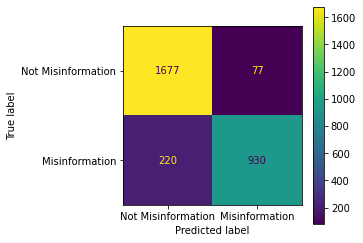

In [15]:
display(Markdown("**WATERLOO-CARDS in cards segment**"))
scores = test_cards['waterloo-cards_proba'].apply(lambda x: sum(x[1:]))
report(test_cards["labels"], test_cards['waterloo-cards_pred'], scores, target_names)

## Sample Labeled

In [16]:
sample_labeled = pd.read_csv("datasets/hamburg_1000_sample.csv")
sample_labeled = sample_labeled[~sample_labeled.label.isna()]
sample_labeled["cards_proba"] = sample_labeled["cards_proba"].apply(format_scores)
sample_labeled["waterloo_proba"] = sample_labeled["waterloo_proba"].apply(format_scores)
sample_labeled["waterloo-cards_proba"] = sample_labeled["waterloo-cards_proba"].apply(format_scores)
sample_labeled.sample()

,id,username,fulltext,label,140_char_text,hashtags,url,domain,retweet_count,favorite_count,...,waterloo_cards_score,date,cards_sum_pred,text,cards_original_pred,cards_proba,waterloo_pred,waterloo_proba,waterloo-cards_pred,waterloo-cards_proba
21,1552924593878335489,the_unhcr,A sustainable future starts with inclusive #Cl...,0_0,A sustainable future starts with inclusive #Cl...,"[{'text': 'ClimateAction', 'indices': [43, 57]...",https://twitter.com/i/web/status/1552924593878...,twitter.com,0.0,1.0,...,0.999971,2022-07-29,0,A sustainable future starts with inclusive #Cl...,0_0,"[0.999747551, 4.67309025e-06, 2.19880565e-06, ...",0,"[0.999992472, 7.52798967e-06]",0,"[0.999971255, 2.87446184e-05]"


In [17]:
def remove_third_level(label):
    if label and isinstance(label, str):
        return re.match("\d_\d", label)[0]
    return 

sample_labeled["label_edit"] = sample_labeled["label"].apply(remove_third_level)

sample_labeled.loc[sample_labeled["label"] == "0_0", "label_sum"] = 0
sample_labeled.loc[sample_labeled["label"] != "0_0", "label_sum"] = 1

**CARDS**

Accuracy: 0.8170865279299014
AUC: 0.8275960170697012
                    precision    recall  f1-score   support

Not Misinformation       0.83      0.95      0.89       703
    Misinformation       0.69      0.37      0.48       210

          accuracy                           0.82       913
         macro avg       0.76      0.66      0.69       913
      weighted avg       0.80      0.82      0.80       913



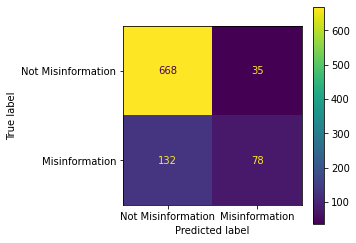

In [18]:
target_names = ["Not Misinformation", "Misinformation"]
scores = sample_labeled.apply(
    lambda x: x['cards_proba'][0] if x['cards_pred'] == "0_0" else sum(x['cards_proba'][1:]), axis=1)
display(Markdown("**CARDS**"))
report(sample_labeled["label_sum"], sample_labeled['cards_sum_pred'], 
       scores, target_names)

**WATERLOO**

Accuracy: 0.891566265060241
AUC: 0.9119318566686987
                    precision    recall  f1-score   support

Not Misinformation       0.91      0.96      0.93       703
    Misinformation       0.82      0.67      0.74       210

          accuracy                           0.89       913
         macro avg       0.87      0.81      0.84       913
      weighted avg       0.89      0.89      0.89       913



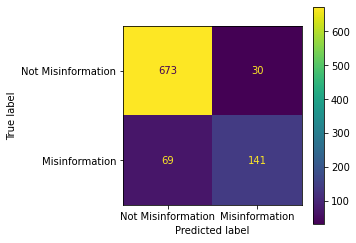

In [19]:
target_names = ["Not Misinformation", "Misinformation"]
scores = sample_labeled.waterloo_proba.apply(
    lambda x: x[1])
display(Markdown("**WATERLOO**"))
report(sample_labeled["label_sum"], sample_labeled['waterloo_pred'], 
       scores, target_names)

**WATERLOO-CARDS**

Accuracy: 0.864184008762322
AUC: 0.8996917970602181
                    precision    recall  f1-score   support

Not Misinformation       0.89      0.94      0.91       703
    Misinformation       0.76      0.60      0.67       210

          accuracy                           0.86       913
         macro avg       0.82      0.77      0.79       913
      weighted avg       0.86      0.86      0.86       913



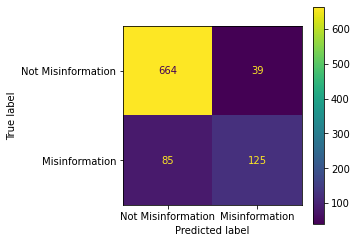

In [20]:
target_names = ["Not Misinformation", "Misinformation"]
scores = sample_labeled["waterloo-cards_proba"].apply(
    lambda x: x[1])
display(Markdown("**WATERLOO-CARDS**"))
report(sample_labeled["label_sum"], sample_labeled['waterloo-cards_pred'], 
       scores, target_names)

**CARDS**

Accuracy: 0.7831325301204819
              precision    recall  f1-score   support

         0_0       0.84      0.95      0.89       703
         1_0       1.00      0.00      0.00         6
         1_3       1.00      0.00      0.00         4
         1_4       0.50      1.00      0.67         1
         1_6       1.00      0.00      0.00         2
         1_7       0.50      0.25      0.33         8
         1_8       1.00      0.00      0.00         5
         2_1       0.88      0.70      0.78        20
         2_3       0.33      0.67      0.44         3
         3_0       1.00      0.00      0.00        12
         3_1       0.00      1.00      0.00         0
         3_2       0.25      1.00      0.40         1
         3_4       1.00      0.00      0.00         1
         3_6       1.00      0.00      0.00         1
         4_1       0.46      0.38      0.41        16
         4_2       0.00      0.00      0.00         5
         4_3       1.00      0.00      0.00         

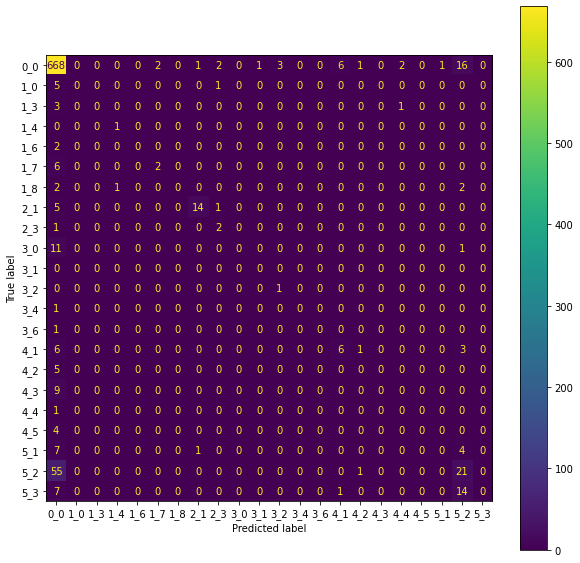

In [21]:
def report(y_true, y_pred, classes=None, size=(4,4)):
    
    acc = accuracy_score(y_true, y_pred)    
    print(f"Accuracy: {acc}")
    print(classification_report(y_true, y_pred, target_names=classes, zero_division=True))
    c_m = confusion_matrix(y_true, y_pred)
    cmp = ConfusionMatrixDisplay(
        c_m, display_labels=classes)
    fig, ax = plt.subplots(figsize=size)
    cmp.plot(ax=ax)
    
display(Markdown("**CARDS**"))
target_names = np.union1d(sample_labeled["label_edit"], sample_labeled["cards_original_pred"])
report(sample_labeled["label_edit"], sample_labeled['cards_original_pred'], target_names, size=(10, 10))